# Forecasting with `sktime`

**OBJECTIVES**

- Basic forecasting workflow with `sktime` library
- Exponential Smoothing models
- Holt Winters Model
- Autoregression
- ARIMA Models

Starting from our last notebook, today we will cover additional forecasting models and further use `sktime` to implement time series forecasting models.  We will use data that is already prepared as we discussed -- datetime index sorted in time.

### Grid Searching a Pipeline

The example below demonstrates gridsearching elements of a pipeline.  How does this work?

In [1]:
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import OneHotEncoder, PolynomialFeatures
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import fetch_openml
from sklearn.compose import make_column_transformer
from sklearn.pipeline import Pipeline
from sklearn import set_config

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [2]:
set_config(transform_output='pandas')

In [3]:
survey = fetch_openml(data_id=534, as_frame=True)

In [4]:
X = survey.data
y = survey.target

In [5]:
X.head()

,EDUCATION,SOUTH,SEX,EXPERIENCE,UNION,AGE,RACE,OCCUPATION,SECTOR,MARR
0,8,no,female,21,not_member,35,Hispanic,Other,Manufacturing,Married
1,9,no,female,42,not_member,57,White,Other,Manufacturing,Married
2,12,no,male,1,not_member,19,White,Other,Manufacturing,Unmarried
3,12,no,male,4,not_member,22,White,Other,Other,Unmarried
4,12,no,male,17,not_member,35,White,Other,Other,Married


In [6]:
cat_cols = X.select_dtypes('category').columns.tolist()

In [7]:
ohe = OneHotEncoder(sparse_output=False, handle_unknown = 'ignore')
transformer = make_column_transformer((ohe, cat_cols), remainder = 'passthrough',
                                     verbose_feature_names_out=False)

In [8]:
forest = RandomForestRegressor()

In [9]:
pipe = Pipeline([('transformer', transformer), ('model', forest)])

In [10]:
#what is happening here?
params = {'model__n_estimators': [10, 100],
          'transformer__remainder': ['passthrough', PolynomialFeatures(interaction_only=True)]}

In [11]:
grid = GridSearchCV(pipe, param_grid=params)

In [12]:
grid.fit(X, y)

GridSearchCV(estimator=Pipeline(steps=[('transformer',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('onehotencoder',
                                                                         OneHotEncoder(handle_unknown='ignore',
                                                                                       sparse_output=False),
                                                                         ['SOUTH',
                                                                          'SEX',
                                                                          'UNION',
                                                                          'RACE',
                                                                          'OCCUPATION',
                                                                          'SECTOR',
                                                                          'MARR'])],
                                                          verbose_feature_names_out=False)),
                                       ('model', RandomForestRegressor())]),
             param_grid={'model__n_estimators': [10, 100],
                         'transformer__remainder': ['passthrough',
                                                    PolynomialFeatures(interaction_only=True)]})

In [13]:
grid.best_params_

{'model__n_estimators': 10, 'transformer__remainder': 'passthrough'}

In [14]:
grid.score(X, y)

0.8363023616584652

Add a search over the `max_depth` parameter of the `RandomForestClassifier` where you consider trees with:

`max_depth = [1, 2, 3, None]`



**Feature Importances**

The `RandomForestRegressor` has `.feature_importances_` determined by the use of a feature in splitting.  Below these are displayed as a DataFrame.

In [15]:
steps = grid.best_estimator_.named_steps

In [16]:
pd.DataFrame(steps['model'].feature_importances_, 
             index = steps['transformer'].get_feature_names_out(),
            columns = ['feature importance'])\
            .sort_values(by = 'feature importance', 
            ascending = False)

,feature importance
AGE,0.264405
EDUCATION,0.236556
EXPERIENCE,0.134478
OCCUPATION_Management,0.040419
SEX_female,0.032601
UNION_member,0.032349
SEX_male,0.031937
OCCUPATION_Service,0.023626
OCCUPATION_Professional,0.022849
SECTOR_Manufacturing,0.019345


### `sktime`

In [17]:
#!pip install sktime[all_extras]

In [18]:
import sktime as skt

In [19]:
from sktime.datasets import load_lynx
from sktime.utils.plotting import plot_correlations, plot_series

### Visualizing Time Series

Initially, it is important to consider a plot of the series.  Here, we are looking at the very least to see if the series has a trend or some kind of seasonality. We will typically also look to the autocorrelation and partial autocorrelation plot.

- `plot_series`
- `plot_correlations`

In [20]:
lynx = load_lynx()

In [21]:
plot_series(lynx);

ImportError: cannot import name '_check_estimator_deps' from 'skbase.utils.dependencies' (/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/skbase/utils/dependencies/__init__.py)

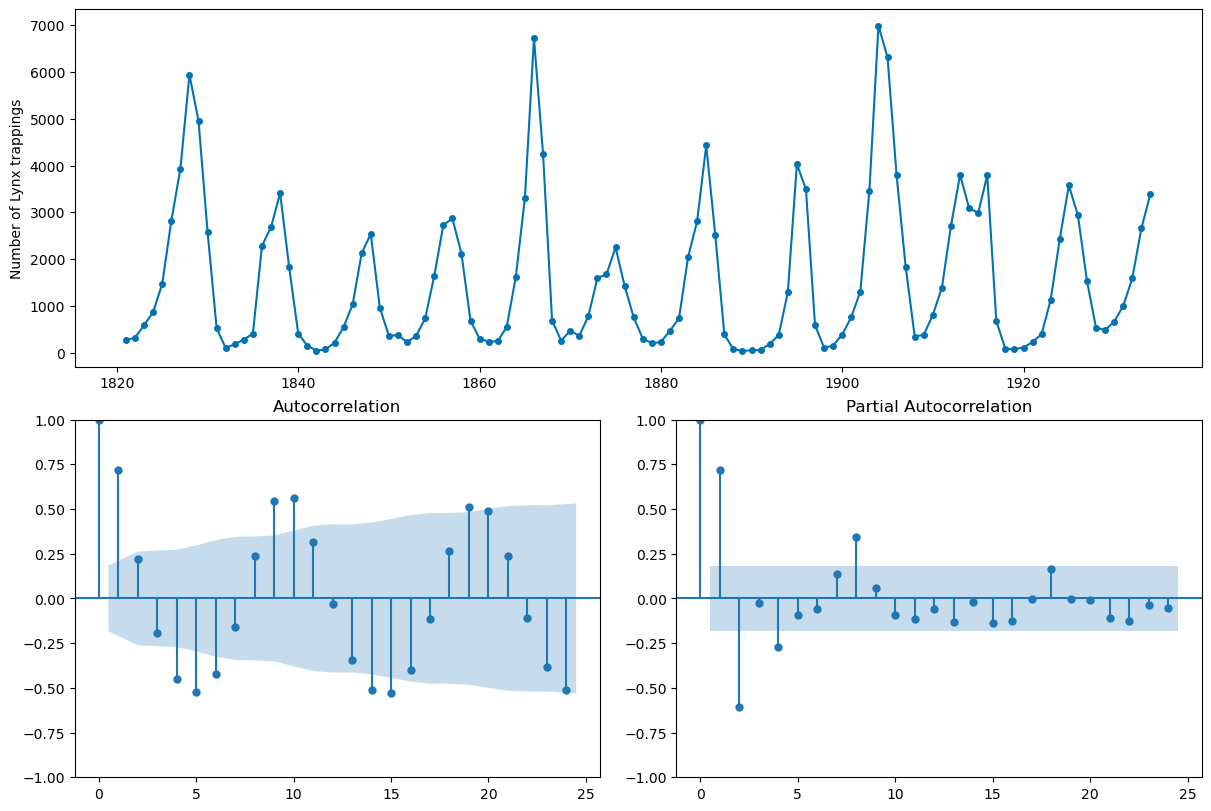

In [30]:
plot_correlations(lynx);

### Forecasting with `sktime`

In [32]:
from sktime.datasets import load_airline

In [33]:
airline = load_airline()

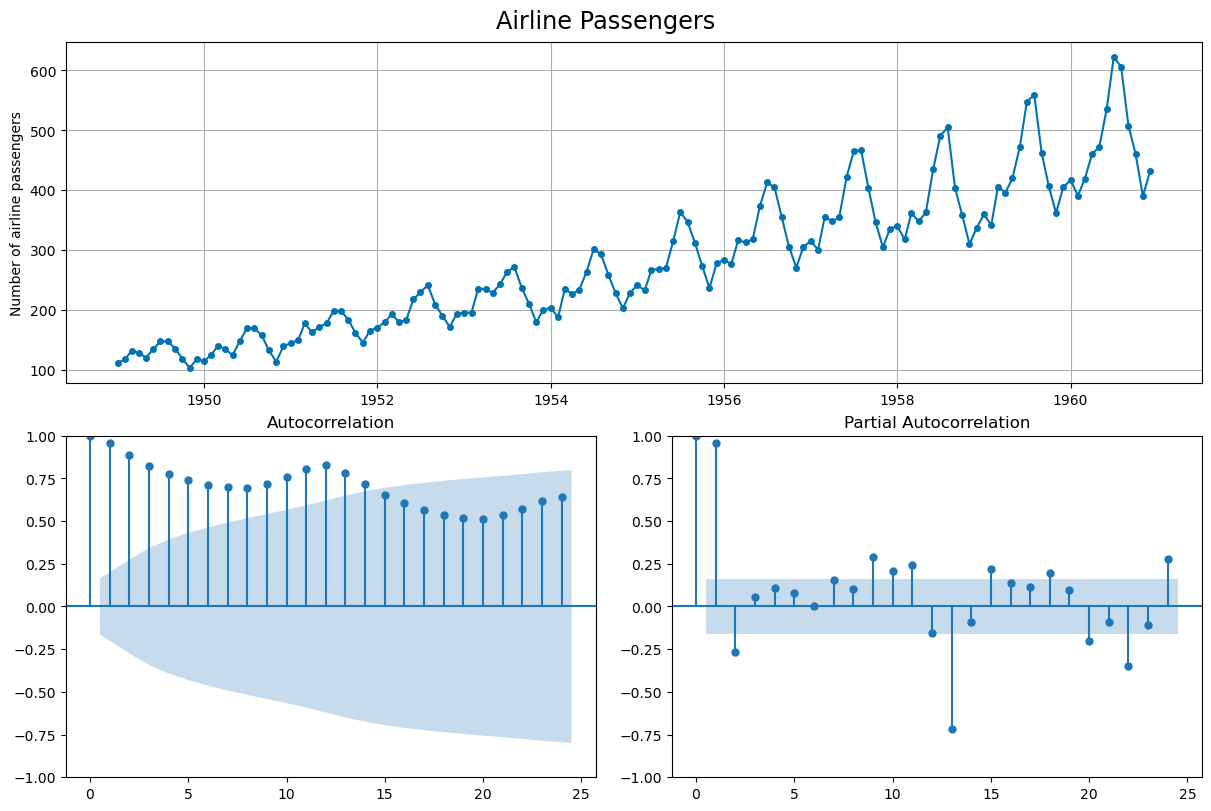

In [34]:
_, ax = plot_correlations(airline, suptitle = 'Airline Passengers')
ax[0].grid()

In [35]:
from sktime.split import temporal_train_test_split

In [36]:
X_train, X_test = temporal_train_test_split(airline)

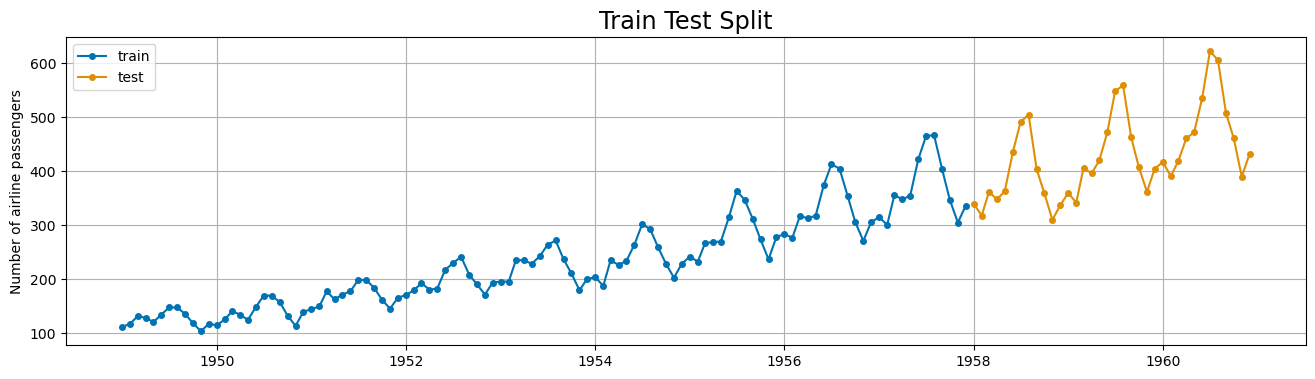

In [37]:
plot_series(X_train, X_test, labels = ['train', 'test'], title = 'Train Test Split')
plt.grid();

### Baseline Model

The `NaiveForecaster` provides multiple strategies for baseline predicitions.  What does `stragey = 'drift'` do?  Plot the predictions along with the train and test data adding appropriate labels.  

In [39]:
from sktime.forecasting.naive import NaiveForecaster

In [40]:
#number of time steps to forecast
fh = np.arange(1, len(X_test)+1)

In [41]:
#instantiate
forecaster = NaiveForecaster(strategy = 'drift')
#fit model
forecaster.fit(X_train)
#predict for horizon
yhat = forecaster.predict(fh)

(<Figure size 1600x400 with 1 Axes>,
 <Axes: ylabel='Number of airline passengers'>)

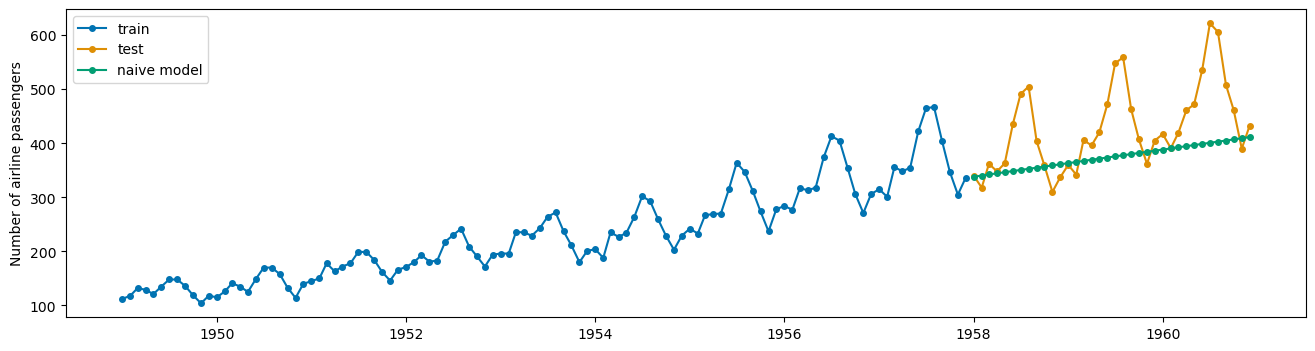

In [42]:
#plot the predictions using plot_series
plot_series(X_train, X_test, yhat, labels = ['train', 'test', 'naive model'])

### Evaluating predictions

`sktime` implements many evaluation metrics.  Below, the `MeanAbsolutePercentageError` class is instantiated and used to evaluated the naive baseline.  Per usual, lower is better.

In [44]:
from sktime.performance_metrics.forecasting import MeanAbsolutePercentageError

In [45]:
mae = MeanAbsolutePercentageError()

In [46]:
mae(X_test, yhat)

0.1299046419013891

### Exponential Smoothing

The weighted moving average model -- very basic and simple; predicts the same value over and over.

In [48]:
from sktime.forecasting.exp_smoothing import ExponentialSmoothing

In [49]:
#instantiate
exp = ExponentialSmoothing()

In [50]:
#fit the model
exp.fit(X_train)

ExponentialSmoothing()

In [51]:
#predict
exp_preds = exp.predict(fh)

In [52]:
#evaluate
mae(X_test, exp_preds)

0.19886712021864697

(<Figure size 1600x400 with 1 Axes>,
 <Axes: ylabel='Number of airline passengers'>)

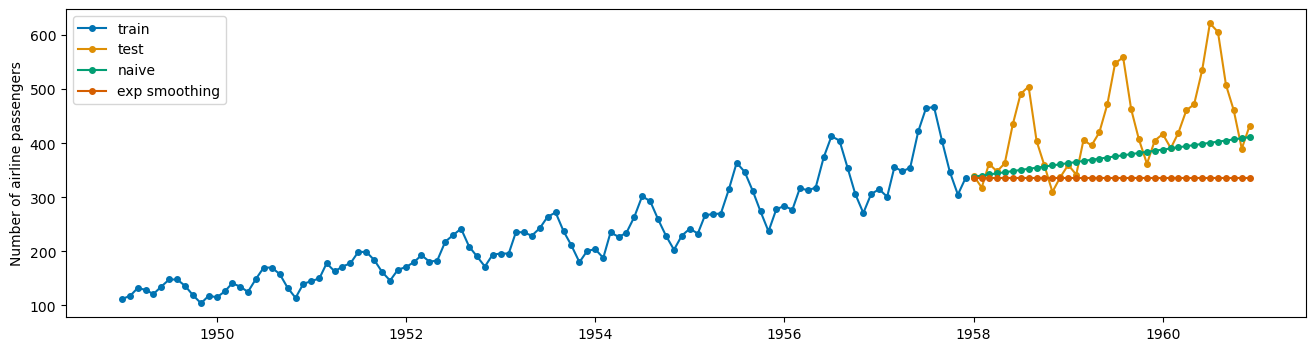

In [53]:
#plot the series
plot_series(X_train, X_test, yhat, exp_preds, labels = ['train', 'test', 'naive', 'exp smoothing'])

### Holt Winters Model

Triple Exponential Smoothing where trend and seasonality are considered.  Below, a holt winters model is implemented.

- trend: always additive
- seasonality: additive if same each season, multiplicative if growing
- sp: timesteps in a season

**QUESTION**: What kind of seasonality should we use here -- additive or multiplicative?  Why?

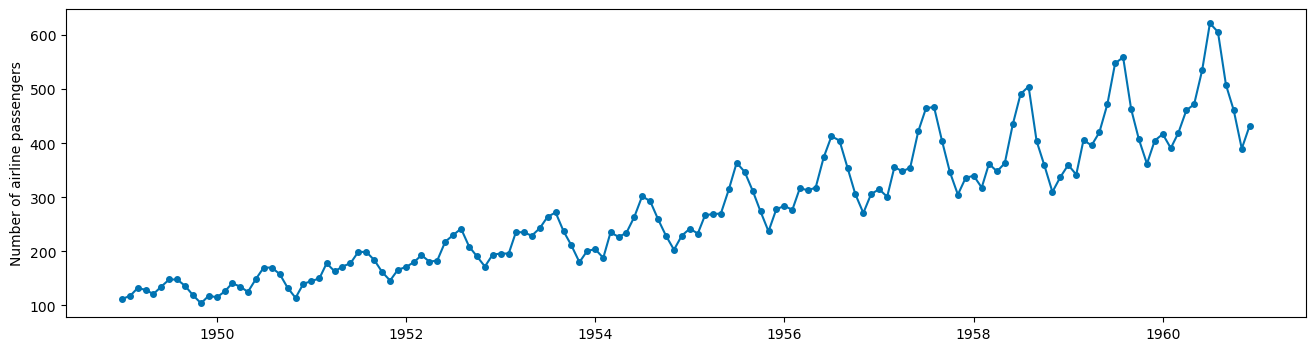

In [56]:
#what kind of seasonality?
plot_series(airline);

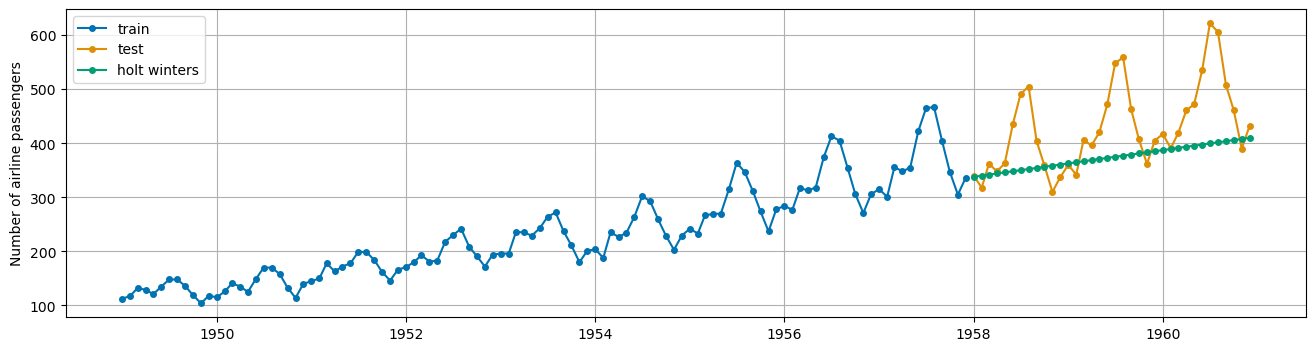

In [57]:
hw = ExponentialSmoothing(trend = 'add', seasonal=None, sp = 12)
hw.fit(X_train)
hw_preds = hw.predict(fh)
plot_series(X_train, X_test, hw_preds, 
            labels = ['train', 'test', 'holt winters'],
           )
plt.grid();

In [58]:
mae(X_test, hw_preds)

0.13092368751018746

### Stationarity and Differencing

Regression models in time series will also have assumptions about the data, namely that the data we model is **stationary**.  Stationary data has constant mean and variance -- thus trends and seasonality are not a part of stationary time series.

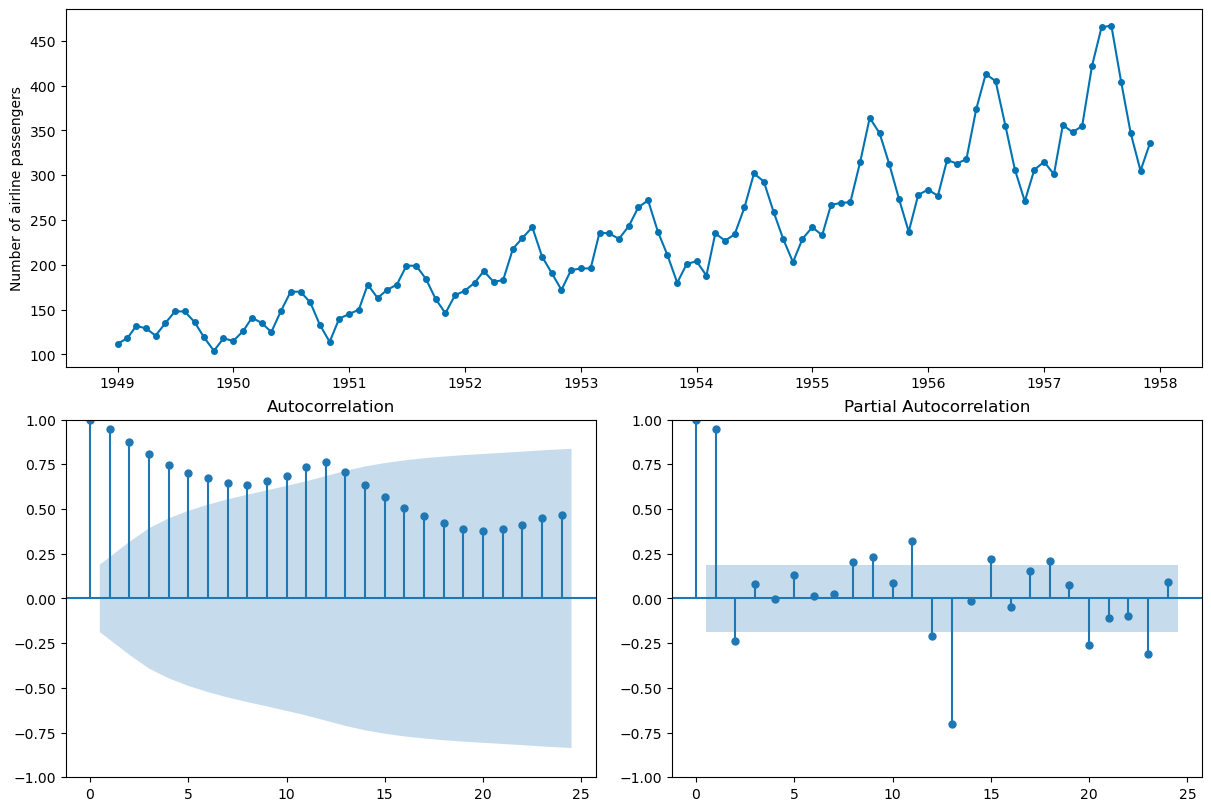

In [60]:
plot_correlations(X_train);

**QUESTION**: Which of the time series pictured below are stationary?  

![](images/stationary-1.png)

### Differencing the Data

One way to remove the trend is to difference the data.  Compare the resulting autocorrelation plot to the undifferenced data.

In [64]:
X_train.diff(1).head()

1949-01     NaN
1949-02     6.0
1949-03    14.0
1949-04    -3.0
1949-05    -8.0
Freq: M, Name: Number of airline passengers, dtype: float64

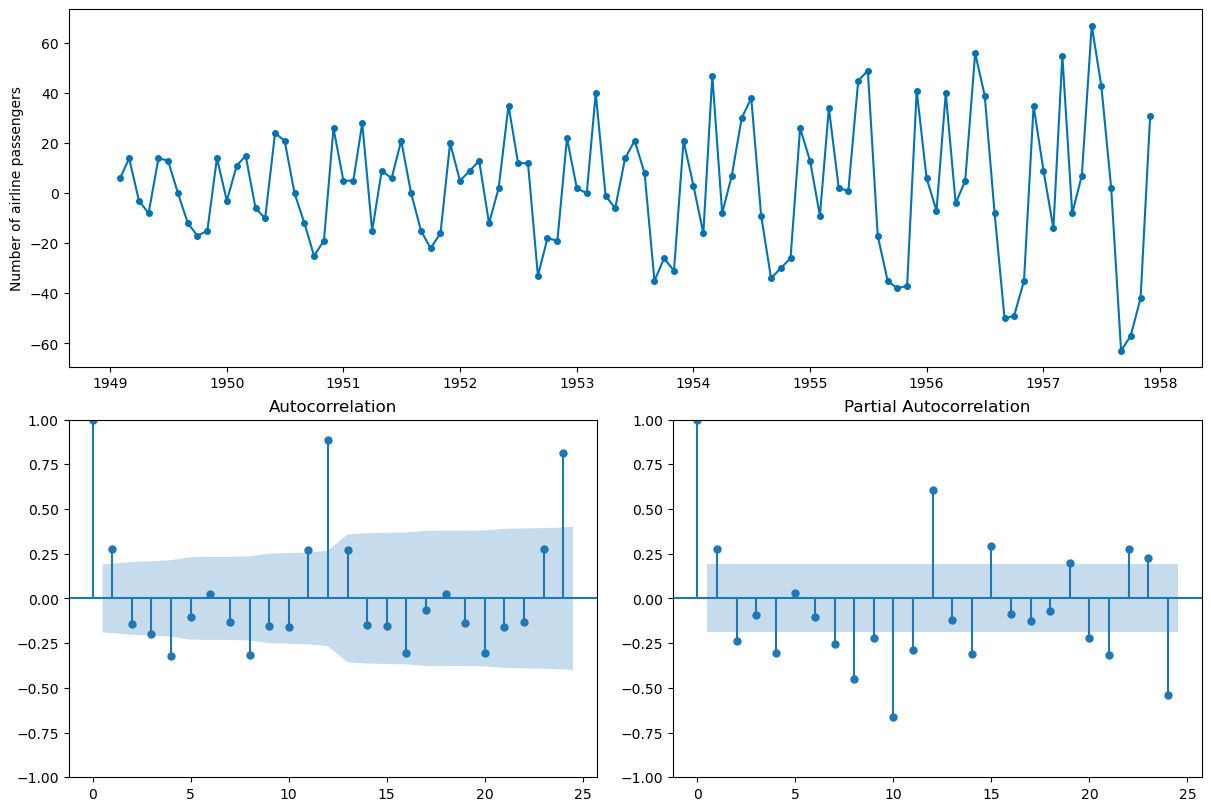

In [65]:
plot_correlations(X_train.diff(1).dropna());

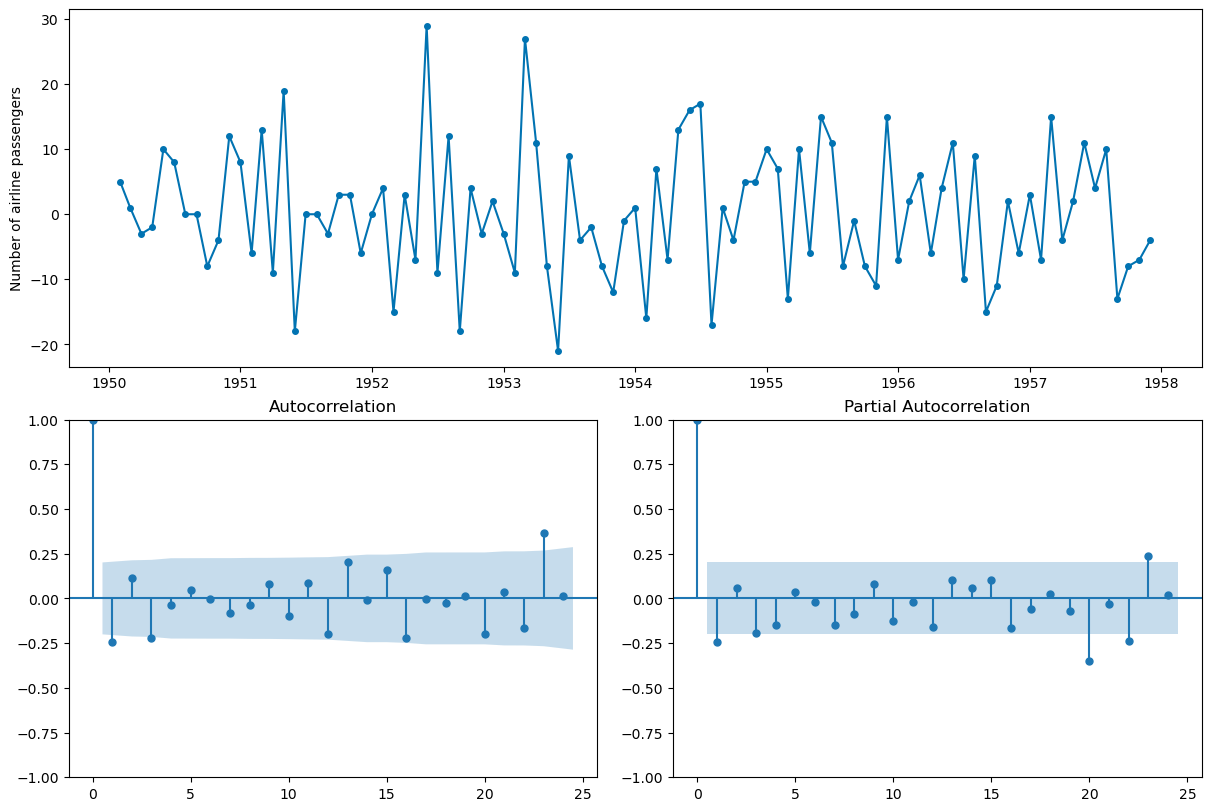

In [66]:
#seasonal differencing to try to remove seasonality -- t and t-12
plot_correlations(X_train.diff(1).diff(12).dropna());

### AutoRegression

Similar to regression however the regression is on previous time steps or "lags".

$$AR(p) = c + \theta_1 y_{t - 1} + \theta_2 y_{t - 2} + ... + \theta_n y_{t - p} + \epsilon$$

In [68]:
from sktime.forecasting.auto_reg import AutoREG

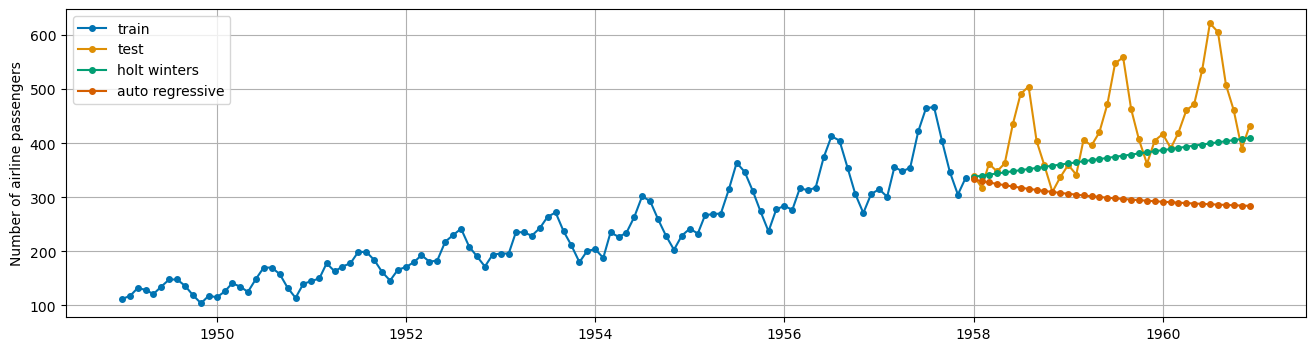

In [69]:
ar = AutoREG(lags = 1)
ar.fit(X_train)
ar_preds = ar.predict(fh)
plot_series(X_train, X_test, hw_preds, ar_preds,
            labels = ['train', 'test', 'holt winters', 'auto regressive'],
           )
plt.grid();

In [70]:
ar.get_fitted_params()

{'aic': 1002.1137403400868,
 'aicc': 1002.3467500488247,
 'bic': 1010.1322268434725,
 'hqic': 1005.3643281466556,
 'const': 13.118081409372074,
 'Number of airline passengers.L1': 0.9520493186942475}

In [71]:
mae(X_test, ar_preds)

0.2714255003209906

**PROBLEM**: Adjusting for lags.  Consider an autoregressive model that uses the 12 previous time steps to forecast.  Is this model better?  Plot the results.

### ARIMA models

- `AR`: Autoregressive component as above
- `MA`: Moving average of errors

$$MA(q) = c + \epsilon_t + \theta_1 \epsilon_{t+1} + ... + \theta_q \epsilon_{t - q}$$
- `ARIMA`: Autoregressive integrated moving average

$$ARIMA(p, q, d) = c + \phi_1 y_{t-1} + \phi_2 y_{t-2} + ... + \phi_p y_{t - p} + \theta_1 \epsilon_{t-1} + ... + \epsilon_{t - q} + \epsilon_t$$

- $p$: order of autoregressive component
- $q$: order of moving average component
- $d$: order of differences of series



In [74]:
from sktime.forecasting.arima import ARIMA

In [75]:
arima = ARIMA(order = (1, 1, 1))

In [76]:
arima.fit(X_train)

ARIMA(order=(1, 1, 1))

In [77]:
arima_preds = arima.predict(fh)

(<Figure size 1600x400 with 1 Axes>,
 <Axes: ylabel='Number of airline passengers'>)

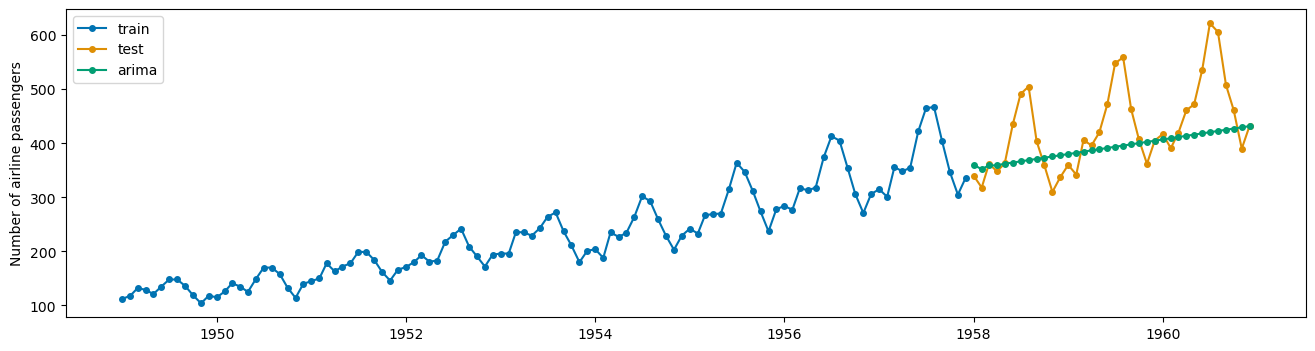

In [78]:
plot_series(X_train, X_test, arima_preds, labels = ['train', 'test', 'arima'])

**PROBLEM**

Try to fit an AutoARIMA model (automatically selects $p,q,d$).  How does this model perform?

In [80]:
from sktime.forecasting.arima import AutoARIMA

In [81]:
#instantiate

#fit

#predict

#print mape

#plot predictions


#### Example: Shampoo Sales

In [83]:
from sktime.datasets import load_shampoo_sales

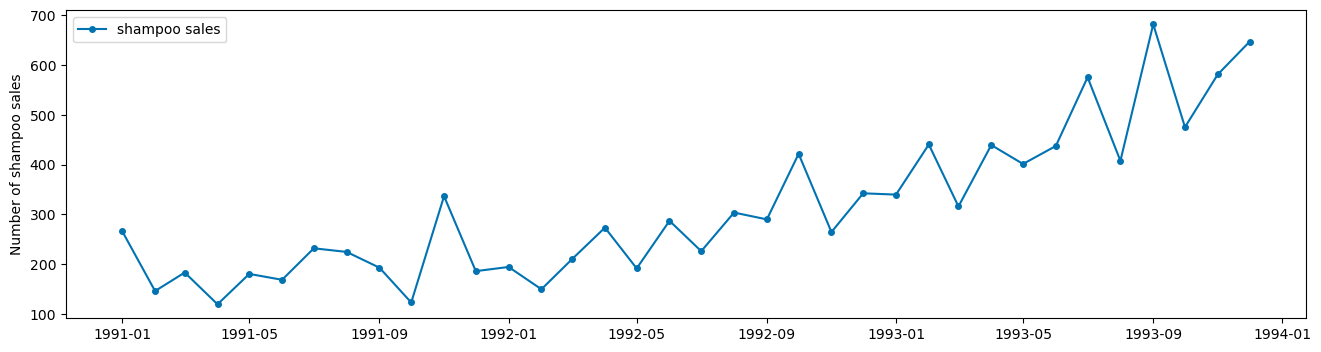

In [84]:
shampoo = load_shampoo_sales()
plot_series(shampoo, labels = ['shampoo sales']);

**PROBLEM**

Split the data into train and test sets to build a Holt Winters model and AutoARIMA model.  Compare performance on the test data and plot the resulting predictions using `plot_series` with appropriate labels.

**Readings or Watchings**:

- Chapter 8.1 - 8.4 of Hyndman [here](https://otexts.com/fpp3/expsmooth.html)
- Chapter 9 of Hyndman on ARIMA models [here](https://otexts.com/fpp3/arima.html#arima)